# Libraries used to get pretrained ViT

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from implemented_functions_to_use.helper_functions import set_seeds

C:\Users\YOGA\.conda\envs\TF1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing which device used to train (CPU or GPU) 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# create a ViT model with pretrained weights
model = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Disable Gradient
for parameter in model.parameters():
    parameter.requires_grad = False
    
# Define the classifier head 
class_names = ['yes','no']

set_seeds()
model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [5]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [6]:
# Setup directory paths to train and test images
train_dir = './archive_for_2_classes/train'
test_dir = './archive_for_2_classes/val'

In [7]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## Turning images into DataLoaders using the create_dataloaders()

In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [12]:
from implemented_functions_to_use.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
model_results = engine.train(model=model,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=1,
                                      device=device)

100%|██████████| 1/1 [02:15<00:00, 135.01s/it]

Epoch: 1 | train_loss: 0.5898 | train_acc: 0.6771 | test_loss: 0.4904 | test_acc: 0.7742


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


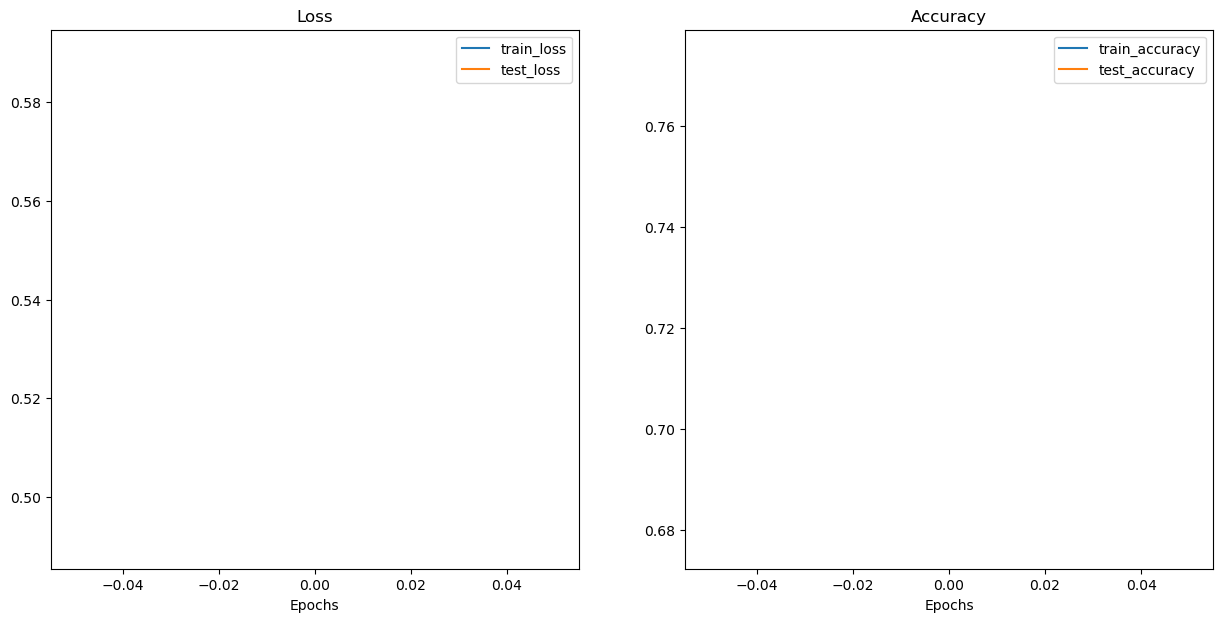

In [13]:
# Plot the loss curves
from implemented_functions_to_use.helper_functions import plot_loss_curves

plot_loss_curves(model_results) 

# Making some Predictions:

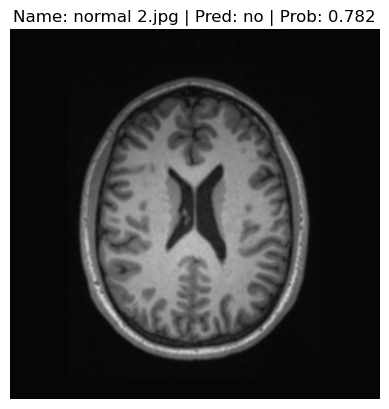

In [14]:
import requests

# Import function to make predictions on images and plot them 
from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "./predict/normal 2.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

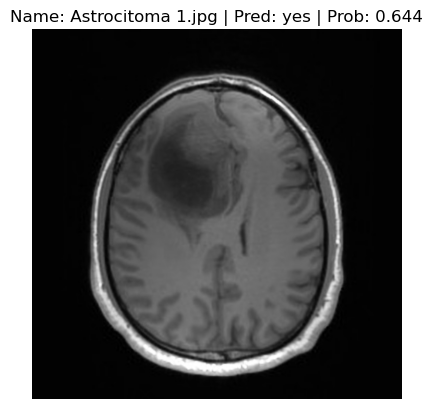

In [15]:
# Import function to make predictions on images and plot them 
from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "./predict/Astrocitoma 1.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

## Save model as file

In [16]:
import pickle

# Saving the model
with open('model(1 Epoch 2 classes).pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully!")


Model saved successfully!


# Load model as file

In [19]:
# Loading the model
name = 'model(1 Epoch 2 classes).pkl'
with open(name, 'rb') as file:
    loaded_model = pickle.load(file)

print("Loaded model:", loaded_model)


Loaded model: VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   

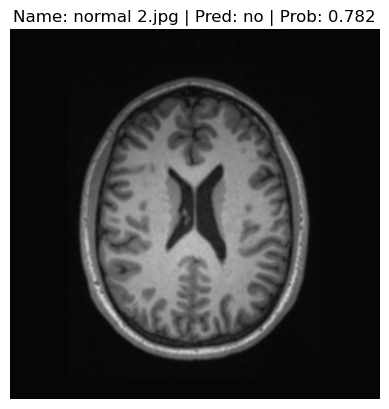

In [20]:
import requests

# Import function to make predictions on images and plot them 
from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "./predict/normal 2.jpg"

# Predict on custom image
pred_and_plot_image(model=loaded_model,
                    image_path=custom_image_path,
                    class_names=class_names)

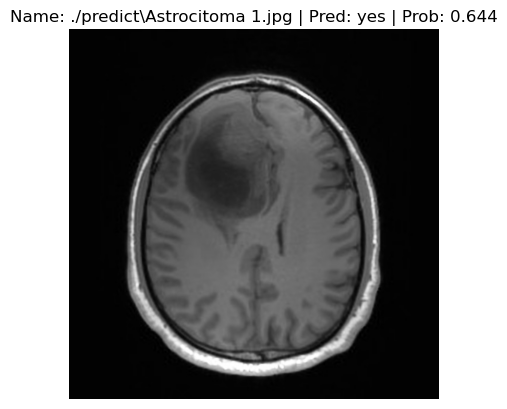

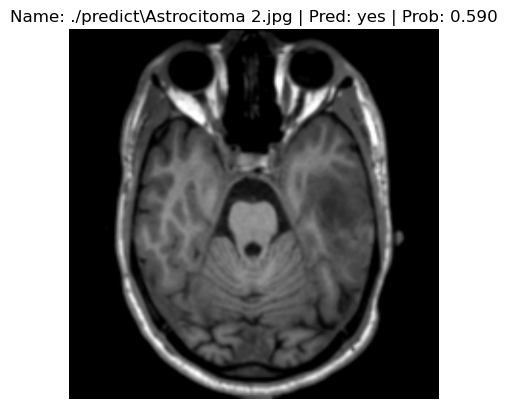

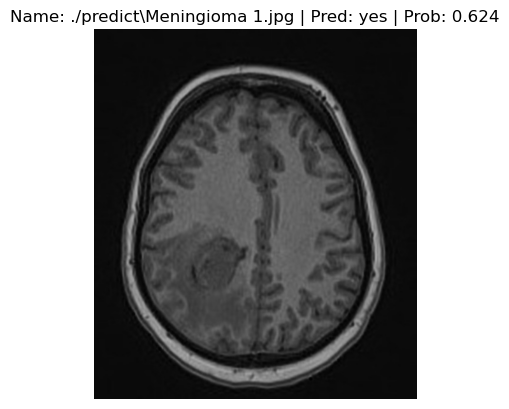

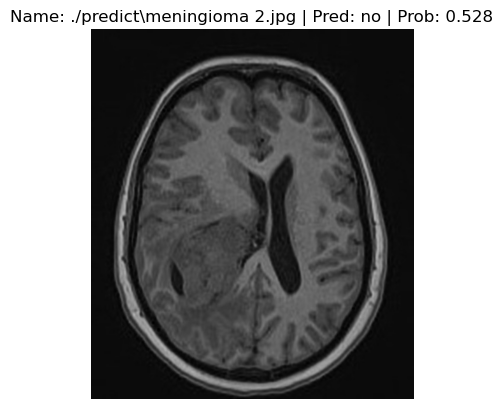

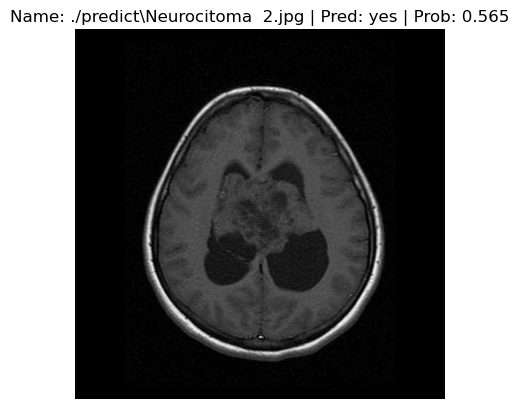

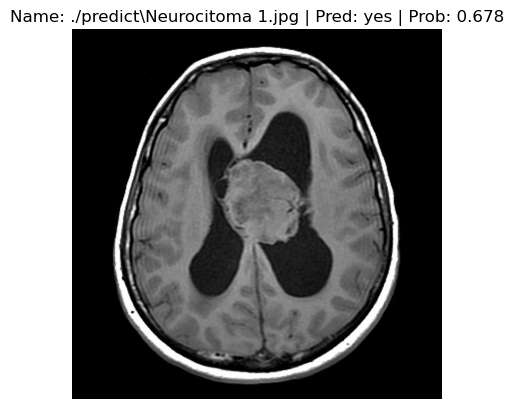

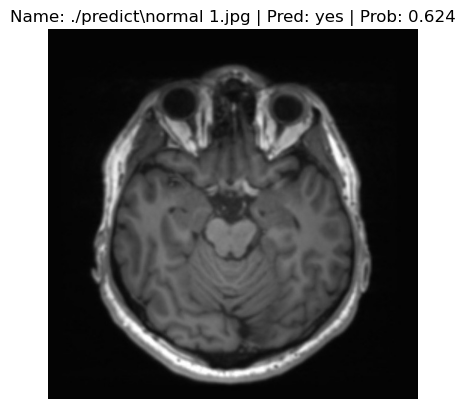

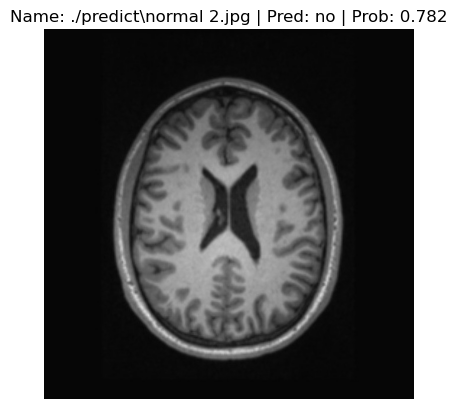

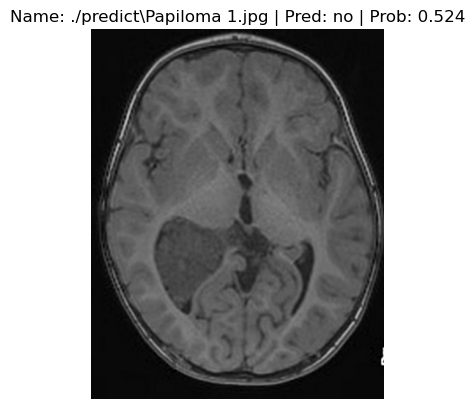

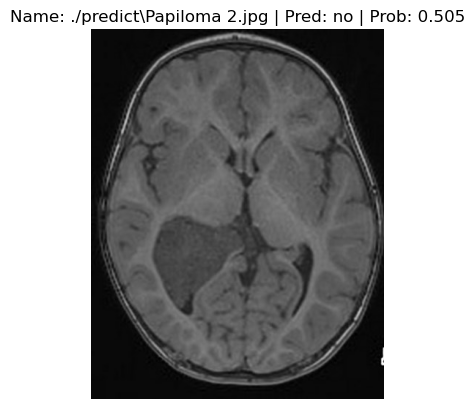

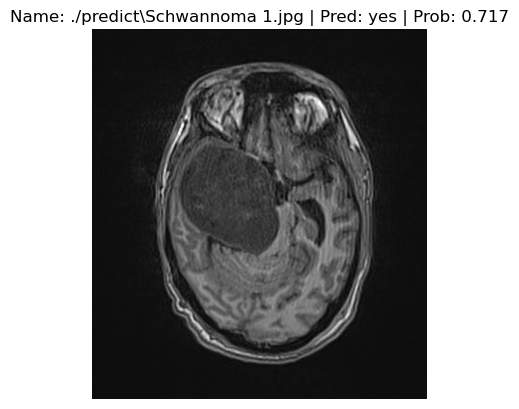

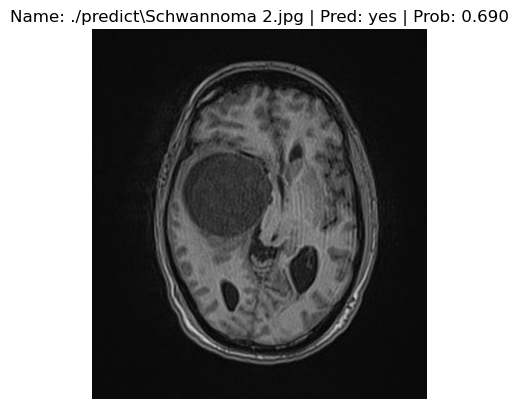

In [21]:
import glob
predict_path = './predict/*.jpg'
for image_path in glob.iglob(predict_path):
    pred_and_plot_image(model=loaded_model,
                    image_path=image_path,
                    class_names=class_names)
    